# Theoretical Recurrence Interval

__Description__:

__Input__: 

__Output__: 

---
## Load Libraries, Parameters, and File Paths:
### Libraries:

In [1]:
import os
import json
import numpy as np
import pandas as pd
import pathlib as pl
from matplotlib import pyplot as plt

### Parameters:
#### Site specific:

In [2]:
Project_Area = 'Brentwood' # Project area name

root_dir = pl.Path(r'C:\Users\sputnam\Desktop\PFRA_Production\Pluvial\{0}'.format(Project_Area))
outputs_dir = root_dir/'Outputs'
tri_dir = outputs_dir/'{0}_Pluvial_TRI'.format(Project_Area)

##### Make a directory to store the theoretical recurrence interval results if it does not already exist:

In [3]:
if not os.path.exists(str(tri_dir)):
    os.makedirs(str(tri_dir))

#### Project specific (global):

In [4]:
binwidth = 0.01       # [inches]; increment for binning the excess rainfall amount
RI_max = 3000

verbose = True        # Option to display print statements
display_plots = True  # Option to display plots

### File Paths:
#### Weights:

In [5]:
weight_files = []
for f in outputs_dir.glob('*.json'):
    if 'Weights' in f.stem: 
        weight_files.append(f)       
        print(f)

C:\Users\sputnam\Desktop\PFRA_Production\Pluvial\Brentwood\Outputs\Brentwood_P01_D01_Weights.json


#### Forcing:

In [6]:
forcing_files = []
for f in outputs_dir.glob('**/*.json'):
    if 'Forcing' in f.parent.stem:
        forcing_files.append(f)
        print(f)

C:\Users\sputnam\Desktop\PFRA_Production\Pluvial\Brentwood\Outputs\Brentwood_P01_Forcing\Brentwood_P01_D01.json


---
## Calculate the Theoretical Recurrence Interval:

P01 D01 Theoretical Threshold RI: 4.288148538392886 years


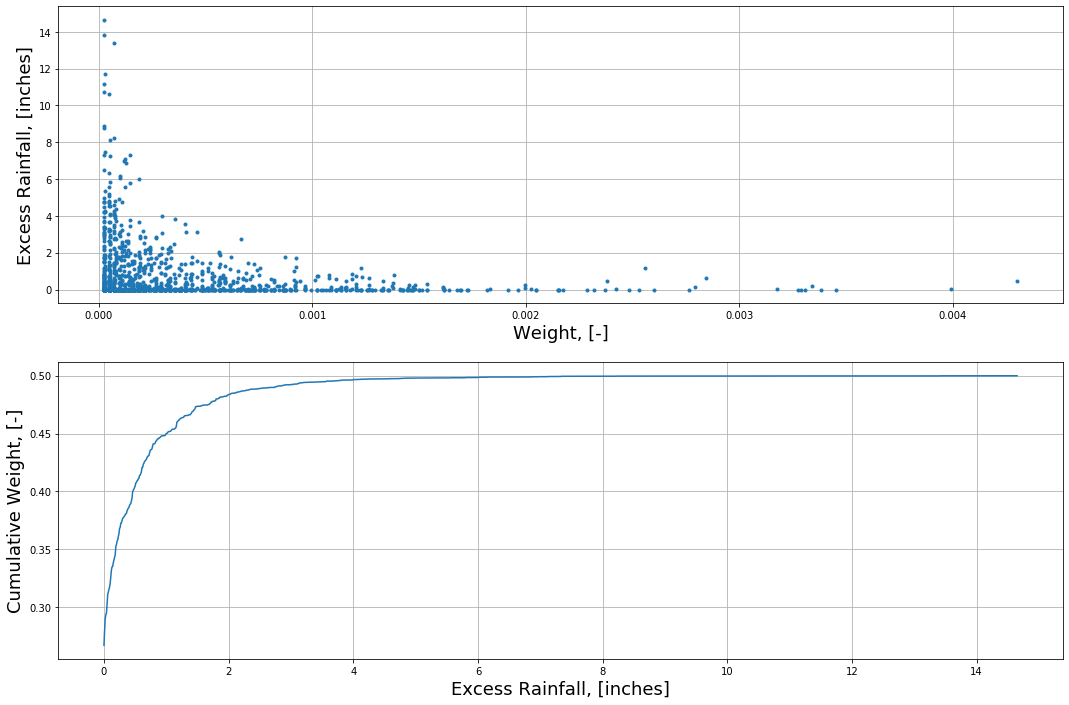

In [7]:
dic = {}
dic_vol = {}
for forcing_file in forcing_files:
    _, Pluvial_Model, Domain = forcing_file.stem.split('_')
    
    for w in weight_files:
        if Pluvial_Model in w.stem:
            weight_file = w
            
    with open(forcing_file) as f:
            ff_dic =  json.load(f)
    
    with open(weight_file) as f:
            wt =  json.load(f)  
            
    mainBCN = list(wt['BCName'].keys())[0]
    
    df = pd.DataFrame()
    df['Events'] = list(wt['BCName'][mainBCN].keys())
    df['Weight'] = list(wt['BCName'][mainBCN].values())    
    df = df.set_index('Events')
    for d in list(ff_dic.keys()):
        for k, v in ff_dic[d]['BCName'][Domain].items():
            df.loc[k, 'Volume'] = sum(v)
            df.loc[k, 'Dur'] = d
    df = df.reset_index().sort_values(by=['Volume'], ascending = True).set_index('Events') 
    
    binmin = min(df['Volume'])
    binmax = max(df['Volume'])
    bins = np.arange(binmin, binmax+binwidth, binwidth)
    
    lst = []
    for i, b in enumerate(bins[:]):
        if i==0:
            weight = sum(df[(0.0 == df['Volume'])]['Weight'])
        else:
            weight = sum(df[(bins[i-1]  < df['Volume']) & (df['Volume']<=b)]['Weight'])
        lst.append((b, weight))
   
    binned  = pd.DataFrame()
    binned['Volume'] = [i[0] for i in lst]
    binned['Weight'] = [i[1] for i in lst]
    binned['Cumulative'] = binned['Weight'].cumsum()
    binned['Theoretical RI'] = 1.0/(0.5-binned['Cumulative'])
    
    k = '{0}_{1}'.format(Pluvial_Model, Domain)
    dic[k] = {}
    dic_vol[k] = {}
    for e in df.index: 
        vol = df.loc[e,'Volume']
        dur = df.loc[e,'Dur']
        ename = '{0}_{1}'.format(dur, e)
        dic_vol[k][ename] = vol
        if vol==0:
            #dic[k][ename] = binned.loc[0, 'Theoretical RI']
            dic[k][ename] = min(round(binned.loc[0, 'Theoretical RI']), RI_max )
        #elif vol==df['Volume'].max():
        #    dic[k][ename] = binned.iloc[-2].loc['Theoretical RI']
        else:
            for j in binned.index[1:]:
                v0 = binned.loc[j-1, 'Volume']
                v1 = binned.loc[j, 'Volume']
                if v0<vol<=v1:
                    #dic[k][ename] = binned.loc[j, 'Theoretical RI']
                    dic[k][ename] = min(round(binned.loc[j, 'Theoretical RI']), RI_max ) 

    TTRI = binned.loc[0]['Theoretical RI']
    
    if verbose:
        print('{0} {1} Theoretical Threshold RI: {2} years'.format(Pluvial_Model, Domain, TTRI))
    if display_plots:
        fig, ax = plt.subplots(2, 1, figsize=(18, 12))
        ax[0].plot(df['Weight'], df['Volume'], linestyle = '', marker = '.')
        ax[0].set_xlabel('Weight, [-]', fontsize = 18)
        ax[0].set_ylabel('Excess Rainfall, [inches]', fontsize=18)
        ax[0].grid()    
        ax[1].plot(binned['Volume'], binned['Cumulative'], linestyle = '-', marker = '')
        ax[1].set_xlabel('Excess Rainfall, [inches]', fontsize = 18)
        ax[1].set_ylabel('Cumulative Weight, [-]', fontsize=18)
        ax[1].grid()    

In [ ]:
#fig, ax = plt.subplots(1, 1, figsize=(18, 6))
writer = pd.ExcelWriter(outputs_dir/'{0}_Pluvial_TRI.xlsx'.format(Project_Area))

for k, v in dic.items():
    tempdf = pd.DataFrame.from_dict(v, orient='index', columns=['TRI'])
    tempdf.index.name = 'Events'
    for e in tempdf.index:
        tempdf.loc[e, 'Volume'] = dic_vol[k][e]
    tempdf['Dur'] = [x.split('_')[0] for x in tempdf.index]
    tempdf = tempdf[tempdf['Dur']=='H24'].copy(deep=True)
    tempdf['dTRI'] = abs(tempdf['TRI']-100.0)  
    tempdf = tempdf.reset_index().sort_values('dTRI').set_index('Events')
    tempdf[:4].drop(columns=['dTRI', 'Dur']).to_excel(writer, sheet_name = '{}'.format(k))
writer.save()    
    

In [ ]:

    tri = list(set(tempdf['TRI']))
    tri.sort()
    volumes = [tempdf[tempdf['TRI']==x]['Volume'][0] for x in tri]
    ax.semilogx(tri, volumes, linestyle = '', marker = '.', label = k)
ax.set_title('{0} Theoretical Recurrence Interval.csv'.format(Project_Area), fontsize=18)
ax.set_xlabel('Theoretical RI, [years]', fontsize = 18)
ax.set_ylabel('Excess Rainfall, [inches]', fontsize = 18)
ax.set_xlim([10,5000])
ax.set_ylim([0.0,14])
ax.set_xticklabels(['{:}'.format(x) for x in ax.get_xticks()])
ax.legend()
plt.show()

In [ ]:
avg_ri = {}
mod_dom = list(dic.keys())
mod = list(set([x.split('_')[0] for x in mod_dom]))
for m in mod:
    avg_ri[m] = {}
    domains = [x for x in mod_dom if m in x]
    n_dom =  len(domains)
    for e in dic[domains[0]].keys():
        if n_dom >1:
            ri_vals = []
            vol_vals = []
            for d in domains:
                ri_vals.append(dic[d][e])
                vol_vals.append(dic_vol[d][e])
            avg_ri[m][e] = [min(int(round(sum(ri_vals)/n_dom)), RI_max), sum(vol_vals)/n_dom]
        else:
            avg_ri[m][e] = [min(int(round(dic[domains[0]][e])), RI_max), dic_vol[domains[0]][e]]

In [ ]:
for k, v in avg_ri.items():
    tempdf = pd.DataFrame.from_dict(v, orient='index', columns=['TRI', 'Volume'])
    tempdf.index.name = 'Events'
    tempdf = tempdf.reset_index().sort_values(by=['TRI']).set_index('Events')
    tempdf.to_csv(tri_dir/'{0}_{1}_TRI.csv'.format(Project_Area, k))
    
    fig, ax = plt.subplots(1, 1, figsize=(18, 6))
    ax.semilogx(tempdf['TRI'], tempdf['Volume'], linestyle = '', marker = '.')
    ax.set_title('{0} {1} Theoretical Recurrence Interval'.format(Project_Area, k), fontsize=18)
    ax.set_xlabel('Theoretical RI, [years]', fontsize = 18)
    ax.set_ylabel('Excess Rainfall, [inches]', fontsize = 18)
    ax.set_xlim([10, 5000])
    ax.set_ylim([0.0, 14])
    ax.set_xticklabels(['{:}'.format(x) for x in ax.get_xticks()])
    plt.savefig(tri_dir/'{0}_{1}_TRI.png'.format(Project_Area, k))    
    plt.show()

In [ ]:
avg_df = pd.DataFrame.from_dict(data = avg_ri['P01'], orient='index', columns = ['RI_Avg', 'Vol'] )
#avg_df['Pdiff'] = np.abs((avg_df['RI_D02']-avg_df['RI_D01'])/((avg_df['RI_D02']+avg_df['RI_D01'])/2))*100.0
avg_df.index.name = 'Events'
avg_df = avg_df.reset_index()
avg_df = avg_df

---
## End